# Retina Face Detection

## 1. Training

In [4]:
pwd

'd:\\python\\object_detection'

In [5]:
# Retina Face train.py 폴더
# cd G:/내 드라이브/Pytorch_Retinaface

In [6]:
#!python train.py --network mobile0.25 --training_dataset ../dataset/wider_face/train/label.txt

## 2. Inference

In [7]:
cd G:/내 드라이브/Pytorch_Retinaface

G:\내 드라이브\Pytorch_Retinaface


### 2-1. Import modules

In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
from models.retinaface import RetinaFace
from data import cfg_mnet, cfg_re50

from layers.functions.prior_box import PriorBox
from utils.nms.py_cpu_nms import py_cpu_nms
from utils.box_utils import decode, decode_landm

### 2-2. HyperParmeter Setting

In [9]:
#--- MobileNet 0.25 ---#
weight_path = './weights/mobilenet0.25_Final.pth'
cfg = cfg_mnet

# #--- Resnet-50 ---#
# weight_path = './weights/Resnet50_Final.pth'
# cfg = cfg_re50

resize = 1                      # image resize
confidence_threshold = 0.02
top_k = 5000
nms_threshold = 0.4
keep_top_k = 750
vis_thres = 0.6

### 2-3. Load Model

In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device : {device}")

model = RetinaFace(cfg, phase = 'test').to(device)
model.load_state_dict(torch.load(weight_path, map_location=device))     # map_location : 학습환경과 별개로 eval device 설정
model.eval()
print(f"Model Loaded on '{device}'!")

device : cuda
Model Loaded on 'cuda'!


### 2.4 Retinaface Inference Function

In [11]:
def retinaface_inf(test_img, model):
    img = np.float32(test_img)
    img_height, img_width, _ = img.shape

    scale = torch.Tensor([img_width, img_height, img_width, img_height])
    img -= (104, 117, 123)
    img = img.transpose(2, 0, 1)
    img = torch.from_numpy(img).unsqueeze(0)
    img = img.to(device)
    scale = scale.to(device)

    tic = time.time()
    loc, conf, landms = model(img)  # Forward-pass

    # prior_data #
    priorbox = PriorBox(cfg, image_size=(img_height, img_width))
    prior_data = priorbox.forward().to(device).data
    # boxes #
    boxes = decode(loc.data.squeeze(0), prior_data, cfg['variance'])
    boxes = (boxes * scale / resize).cpu().numpy()
    # scores #
    scores = conf.squeeze(0).data.cpu().numpy()[:, 1]
    # landms #
    landms = decode_landm(landms.data.squeeze(0), prior_data, cfg['variance'])
    scale1 = torch.Tensor([img.shape[3], img.shape[2],
                           img.shape[3], img.shape[2], 
                           img.shape[3], img.shape[2], 
                           img.shape[3], img.shape[2],
                           img.shape[3], img.shape[2]]).to(device)
    
    landms = (landms * scale1 / resize).cpu().numpy()

    # Filter low score boxes
    inds = np.where(scores > confidence_threshold)[0]
    boxes = boxes[inds]
    scores = scores[inds]
    landms = landms[inds]

    # keep top-K before NMS
    order = scores.argsort()[::-1][:top_k]
    boxes = boxes[order]
    scores = scores[order]

    # NMS Processing
    dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
    keep = py_cpu_nms(dets, nms_threshold)
    dets = dets[keep, :]

    # Keep top-K faster NMS
    dets = dets[:keep_top_k, :]

    # dets = np.concatenate((data, landms), axis=1)
    print('Net Forward time: {:.4f}'.format(time.time() - tic))
    fps_ = round(1/(time.time() - tic), 2)
    print('fps_ :', fps_)

    # draw box
    for b in dets:
        if b[4] < vis_thres:
            continue
        text = "{:.4f}".format(b[4])
        b = list(map(int, b))
        cv2.rectangle(test_img, (b[0], b[1]), (b[2], b[3]), (255, 0, 0), 2)
        cv2.putText(test_img, text, (b[0], b[1]-6), cv2.FONT_HERSHEY_DUPLEX, 0.5, (255,255,255), thickness=1, lineType=cv2.LINE_AA)
        
    cv2.putText(test_img, "retinaface", (410, 60), cv2.FONT_HERSHEY_DUPLEX, 1, (255,0,0), thickness=2, lineType=cv2.LINE_AA)
    cv2.putText(test_img, "fps : "+str(fps_), (10, 60), cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 255), thickness=2, lineType=cv2.LINE_AA)
    
    return test_img


Net Forward time: 0.2472
fps_ : 4.04


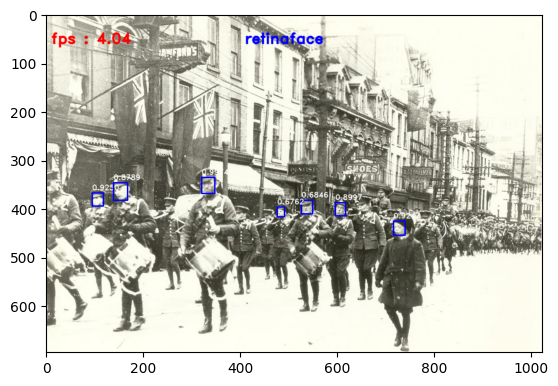

Net Forward time: 0.0551
fps_ : 18.17


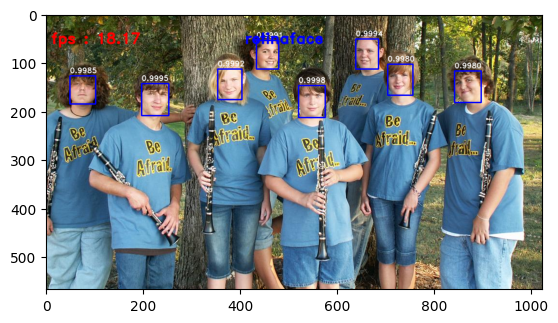

Net Forward time: 0.1431
fps_ : 6.99


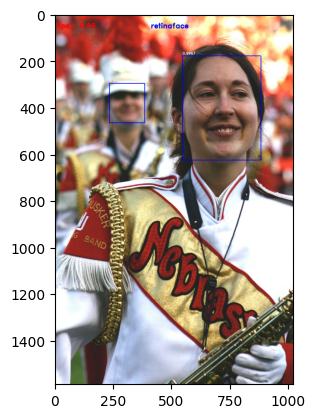

Net Forward time: 0.0811
fps_ : 12.33


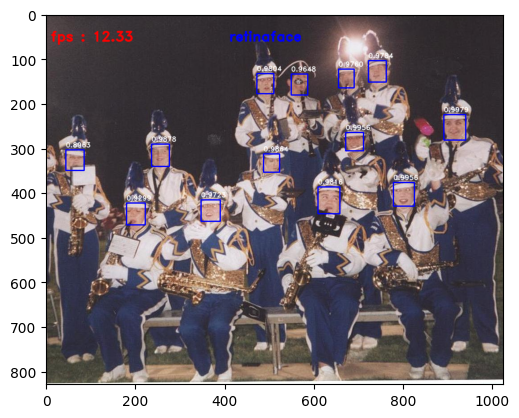

Net Forward time: 0.0571
fps_ : 17.53


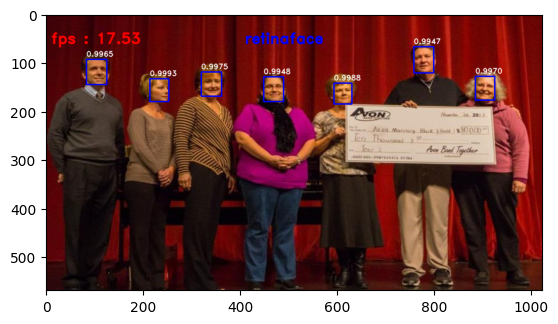

Net Forward time: 0.0741
fps_ : 13.5


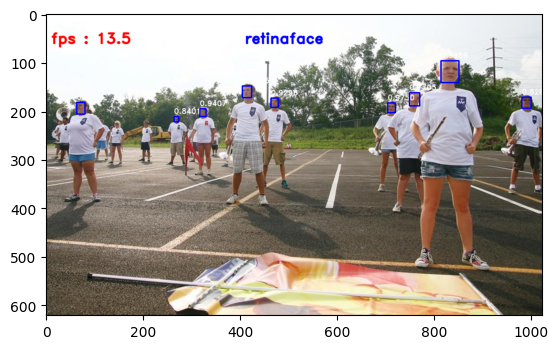

Net Forward time: 0.1872
fps_ : 5.34


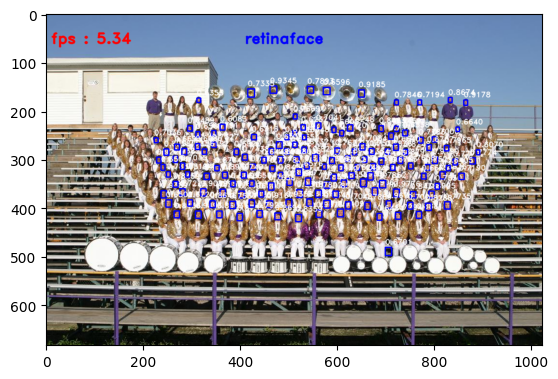

Net Forward time: 0.0831
fps_ : 12.04


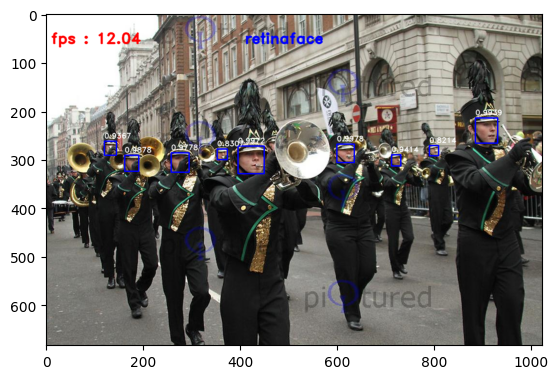

Net Forward time: 0.1281
fps_ : 7.81


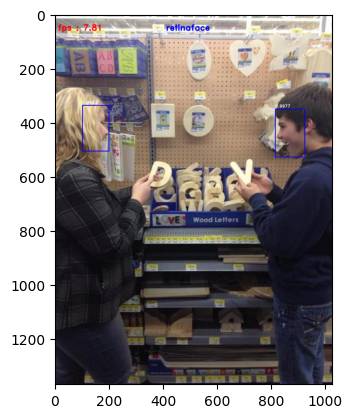

Net Forward time: 0.0831
fps_ : 12.04


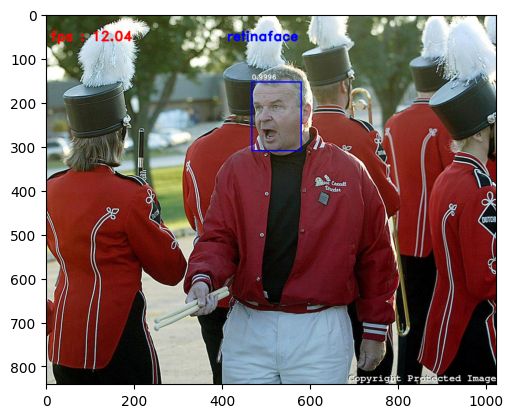

In [71]:
import glob

detect_num = 10
itr = 0
test_path = test_path = '../dataset/wider_face/test/images/0--Parade'
for img_path in glob.glob(test_path+"/*.jpg"):
    test_img = cv2.imread(img_path)
    result_retina = retinaface_inf(test_img, model)
    plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
    plt.show()
    itr += 1
    if itr == detect_num: break

### 2-5. Dlib Inference 함수

In [63]:
import dlib
face_detector = dlib.get_frontal_face_detector()

In [64]:
def dlib_inf(test_img, face_detector):
    img = np.float32(test_img)
    img_height, img_width, _ = img.shape

    tic = time.time()
    face_detection = face_detector(test_img)
    fps_ = round(1/(time.time() - tic), 2)
    for f in face_detection:
        cv2.rectangle(test_img, (f.left(), f.top()), (f.right(), f.bottom()), (0,0,255), 4)
    cv2.putText(test_img, "dlib", (410, 60), cv2.FONT_HERSHEY_DUPLEX, 1, (255,0,0), thickness=2, lineType=cv2.LINE_AA)
    cv2.putText(test_img, "fps : "+str(fps_), (10, 60), cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 255), thickness=2, lineType=cv2.LINE_AA)

    return test_img

# 3. Comparison : RetinaFace vs Dlib

Net Forward time: 0.1351
fps_ : 7.4


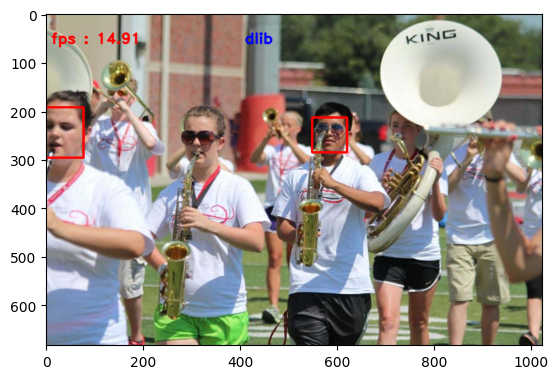

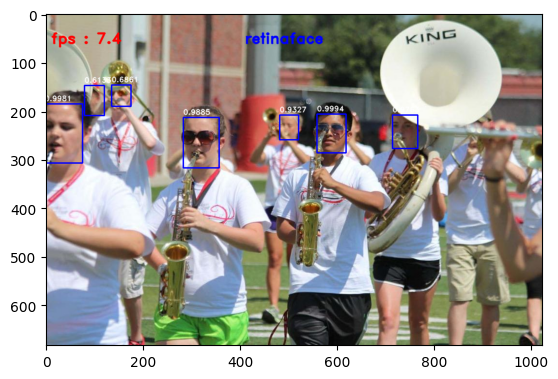

In [75]:
test_path = "../dataset/wider_face/test/images/0--Parade/0_Parade_marchingband_1_773.jpg"
test_img = cv2.imread(test_path)
test_img2 = test_img.copy()

result_dlib = dlib_inf(test_img, face_detector)
result_retina = retinaface_inf(test_img2, model)


plt.imshow(cv2.cvtColor(result_dlib, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(result_retina, cv2.COLOR_BGR2RGB))
plt.show()
